# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

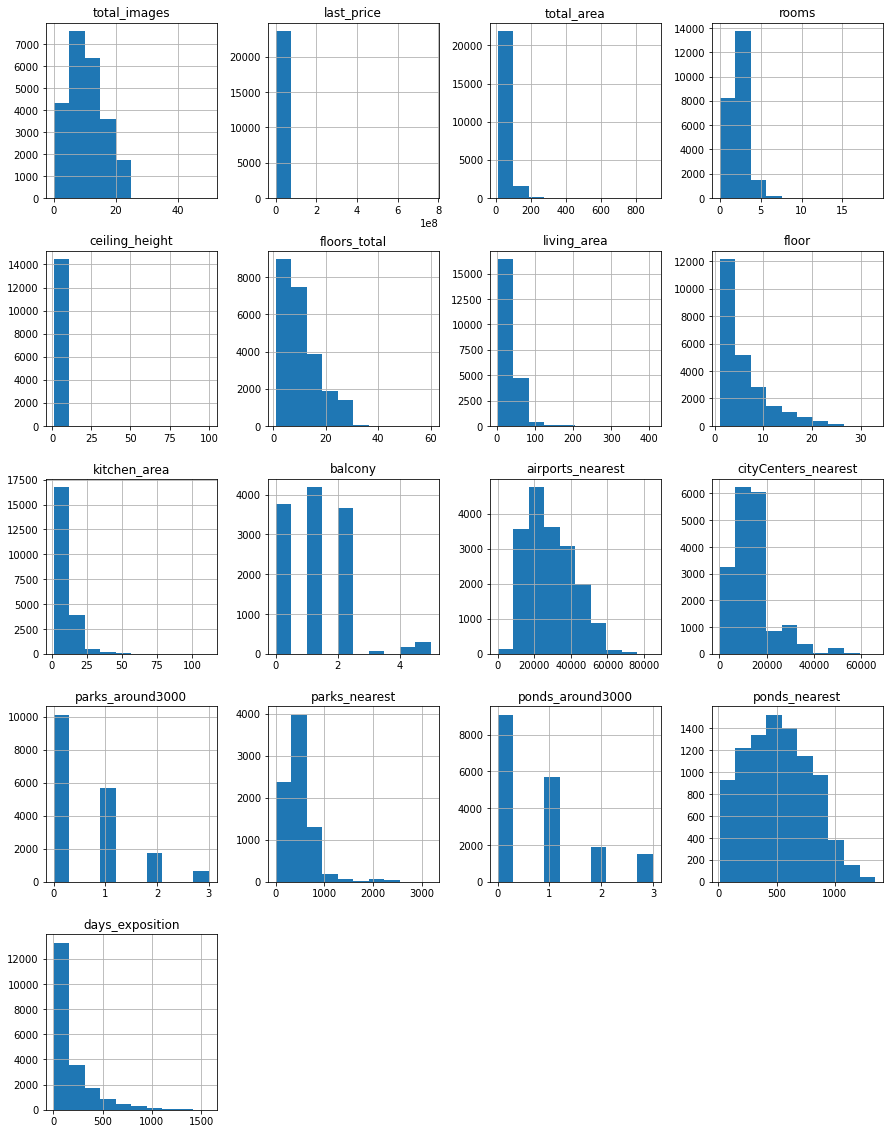

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.head())
data.info()
data.hist(figsize=(15, 20))
shape = data.shape
print(shape)

### Предобработка данных

In [2]:
print(data.isna().sum())
print(data['ceiling_height'].describe())
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'].unique()
data['is_apartment'] = data['is_apartment'].fillna(False)
print(data['kitchen_area'].describe())
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].mean())
data = data.dropna(subset = ['locality_name'])
data = data.dropna(subset = ['floors_total'])
index = data.dropna(subset = ['living_area'])
data['living_area'] = data['living_area'].fillna((index['living_area'].sum() / index['total_area'].sum()) * data['total_area'])

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64
count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64
count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50% 

Предобработка данных:

Высота потолков - пропуски заполнены медианным значением.

Балкон - пропуски заполнены нулями. Скорее всего, отсутствие балкона не заполнялось нулем, а пропускалось к заполнению.

Апартаменты - аналогично балконам.

Размер кухни - пропуски заполнены средним значением, так как, предварительно, аномалий не видно.

Такие данные как: город, количество этажей - пропуски в этих данных были удалены, так как невозможно заполнить пропуски в данных, не искажая данные, а сами данные, по предварительной оценке, крайне важны для объекта недвижимости к исследованию.

Жилая площадь - данный параметр крайне важен для исследования и не может быть просто удален или пропущен. В связи с чем было принято решение найти коэффициент жилого квадратного метра к общему в данных и, ввиду отсутствия пропусков в графе total_area, мы можем заполнить пропуски жилой площади, не нарушая главное правило "кол-во жилых квадратов < кол-во общих квадратов"

In [3]:
#types
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
print(data.isna().sum())
print(data.info())
data.head()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  f

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,25.000000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,11.000000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,...,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,91.211805,9,False,...,10.569807,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,41.000000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Типы данных:

floors_total - int

balcony - int

parks_around3000 - int

ponds_around3000 - int

first_day_exposition - datetime

In [4]:
#duplicates
print(data['locality_name'].duplicated().sum())
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name_clear'] = (data['locality_name'].str.replace('ё', 'е').replace(['городского типа', 'поселок', 'деревня', 'село', 'садовое товарищество', 'коттеджный'], '', regex=True))
print(data['locality_name_clear'].value_counts(ascending = False))
print(data['locality_name_clear'].duplicated().sum())
print(data['locality_name_clear'].unique())

23201
санкт-петербург     15651
 мурино               552
 шушары               439
всеволожск            398
пушкин                369
                    ...  
 гладкое                1
 гончарово              1
 большое рейзино        1
 шпаньково              1
 мыза-ивановка          1
Name: locality_name_clear, Length: 325, dtype: int64
23240
['санкт-петербург' ' шушары' 'городской  янино-1' ' парголово' ' мурино'
 'ломоносов' 'сертолово' 'петергоф' 'пушкин' ' кудрово' 'коммунар'
 'колпино' '  красный бор' 'гатчина' ' федоровское' 'выборг' 'кронштадт'
 'кировск' ' новое девяткино' ' металлострой' '  лебяжье' '  сиверский'
 ' молодцово' '  кузьмоловский' ' новая ропша' 'павловск' ' пикколово'
 'всеволожск' 'волхов' 'кингисепп' 'приозерск' 'сестрорецк' ' куттузи'
 ' аннино' '  ефимовский' ' плодовое' ' заклинье' ' торковичи'
 ' первомайское' 'красное ' ' понтонный' 'сясьстрой' ' старая'
 ' лесколово' ' новый свет' 'сланцы' ' путилово' 'ивангород' 'мурино'
 'шлиссельбург' 'никольско

Дубликаты:

Чистка от дубликатов проводилась в столбце 'locality_name'. 

Сначала была осуществена очитска данных от верхних регистров. Далее было предположено, что распространенная дилемма русского языка - e/ё так же коснулась и наших данных. От буквы ё избавились. Более того, предположено, что заполнение одного и того же населенного пункта может быть различно, если публикующий объявление путает понятие "деревня" и "поселок". От таких ошибок избавились.

### Посчитайте и добавьте в таблицу новые столбцы

In [5]:
data['price_per_1m'] = data['last_price'] / data['total_area']

Цена за квадратный метр: Полная стоимость объекта / Общая площадь квартиры


In [6]:
data['day_numb'] = data['first_day_exposition'].dt.weekday
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

День, Месяц, Год:
День недели заполнен в соответствии с функцией dt.weekday. Воскресенье - 0, Суббота - 6.


In [7]:
def floor_type(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis = 1)

Тип этажа: 
    
    Для формирование нового столбца по типу этажа была использована самодельная функция, которая категоризирует этаж объекта.

In [8]:
data['citycenter_km'] = data['cityCenters_nearest'] / 1000
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
4             2  10000000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16    51.000000      8         False  ...   
1            2.65            11    18.600000      1         False  ...   
2            2.65             5    34.300000      4         False  ...   
3            2.65            14    91.211805      9         False  ...   
4            3.03            14    32.000000     13         False  ...   

   ponds_around3000  ponds_nearest  days_exposition  locality_name_clear  \
0               2.0          755.0              NaN 

Расстояние до центра города в км: 

в 1 км 1000 м, следовательно, заполняем столбец с данными по расстоянию, деленными на 1000.

### Проведите исследовательский анализ данных

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64
count    23565.000000
mean        34.604740
std         22.384903
min          2.000000
25%         19.000000
50%         30.000000
75%         42.100000
max        409.700000
Name: living_area, dtype: float64
count    23565.000000
mean        10.561825
std          5.615539
min          1.300000
25%          7.300000
50%         10.000000
75%         11.410000
max        112.000000
Name: kitchen_area, dtype: float64
count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64
count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max    

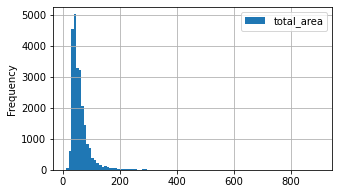

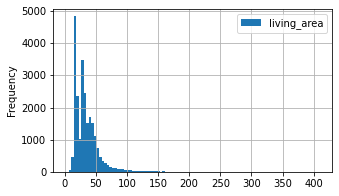

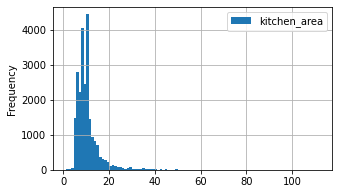

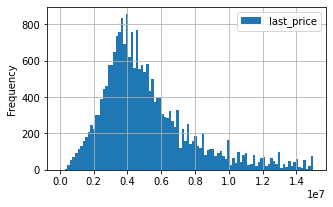

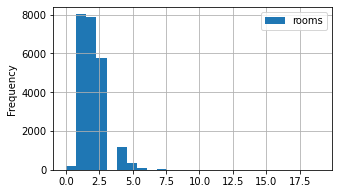

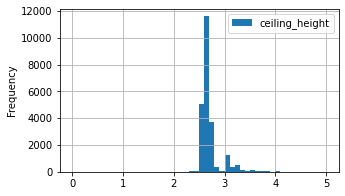

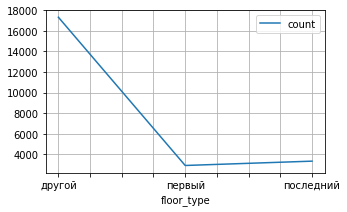

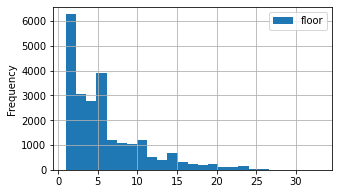

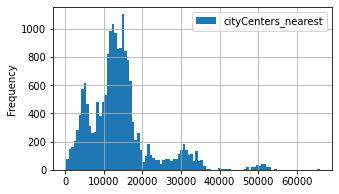

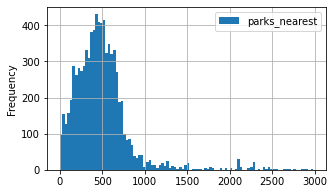

In [9]:
#total_area
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3))
print(data['total_area'].describe())
#living_area
data.plot(y = 'living_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3))
print(data['living_area'].describe())

#kitchen_area
data.plot(y = 'kitchen_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3))
print(data['kitchen_area'].describe())

#last_price
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,15000000), figsize = (5,3))
print(data['last_price'].describe())

#rooms
data.plot(y = 'rooms', kind = 'hist', bins = 25, grid=True, figsize = (5,3))
print(data['rooms'].describe())

#ceiling_height
data.plot(y = 'ceiling_height', kind = 'hist', bins = 50, grid=True, range = (0,5), figsize = (5,3))
print(data['ceiling_height'].describe())
print(data['ceiling_height'].sort_values(ascending = False))

#floor_type
floor_type = data.pivot_table(index = 'floor_type', values = 'last_price', aggfunc = ['count'])
floor_type.columns = ['count']
floor_type.plot(y = 'count', grid=True, figsize = (5,3))

#floor
data.plot(y = 'floor', kind = 'hist', bins = 25, grid=True, figsize = (5,3))
print(data['floor'].describe())

#cityCenters_nearest
data.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 100, grid=True, figsize = (5,3))
print(data['cityCenters_nearest'].describe())

#parks_nearest
parks_df = data.query('parks_around3000 != 0')
parks_df.plot(y = 'parks_nearest', kind = 'hist', bins = 100, grid=True, figsize = (5,3))
print(parks_df['parks_nearest'].describe())

shape_after = data.shape
print(shape_after)

 
Анализ: 
1. Большая часть квартир имеет метраж от 30 до 80 кв.м., пик приходится на 50 кв.м. Есть квартиры и по 800м, но это единичные выбросы.
2. Цена на квартиры лежит в промежутке от 3 до 12 млн. Большая часть квартир продается за цену в промежутке между 3 и 6 млн. Опять же, есть выбросы.
3. Большая часть квартир имеют 1 или 2 комнаты, чуть меньший процент имеют 3 комнаты и небольшое количество - 4. Есть и квартиры, имеющие больше комнат, но их процент сильно ниже.
4. Квартиры, в большинстве своем, имеют потолки от 2,5-2,75м (самый популярный вариант) до 3,2м. Остальные случаи - эксклюзивы.
5. Квадратура большинства кухонь не достигает 20 кв. м, но существуют квартиры и с большими кухнями.
6. Самые редкие квартиры на рынке - квартиры на 1-ом этаже. На последнем этаже примерно на 40% квартир на рынке. Не смотря на это, суммарно первый и последний этаж составляют всего 20% от общего числа квартир, реализуемых на рынке.
7. Абсолютное большинство квартир находится в нижней части дома, не выше 5 этажа.
8. В среднем квартиры находятся на расстоянии 10-20 км от центра. Есть объекты и в 60 км от центра.
9. Справедливо, что, если парка рядом нет, то и расстояние до него не может быть рассчитано, следовательно, такие случаи были заполнены нулями. Чтобы график был нагляднее, данные по расстоянию до ближайшего парка были взяты без квартир с 0 парков поблизости. В среднем, квартиры находятся в полукилометре от парковой зоны.

После предобработки данных, датафрейм похудел на 650 строк, что составляет 3% от изначальных данных. Следовательно, можно продолжать анализ без опасений искажения.
(23025, 33)
(23699, 22)


AxesSubplot(0.125,0.125;0.775x0.755)


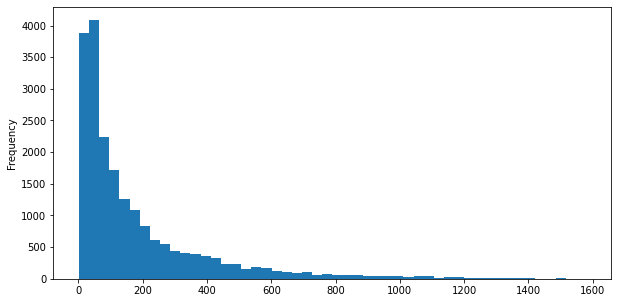

In [10]:
# #days_exposition
data['days_exposition'].describe().to_frame()
data['days_exposition'].median()
print(data['days_exposition'].plot(kind = 'hist', bins=50, figsize=(10,5)))
#print(data.boxplot(column = 'days_exposition'))
#data.query('days_exposition < 500')['days_exposition'].hist(bins = 100, figsize = (10, 5))
#data.query('40 < days_exposition < 100')['days_exposition'].hist(bins = 100, figsize = (10, 5))
data = data.loc[(data['days_exposition'] != 45) & 
                (data['days_exposition'] != 60) &
               (data['days_exposition'] != 90)]

Анализ скорости продажи квартиры:
    Большинство квартир реализованы за 50 дней и менее. Распределение нормальное, что отражает редкость такого явления, как продажа квартиры больше 400 дней.
    Построив ящик с усами, можем заметить, что выбросами являются сделки спустя 500 дней и более. Для более детального анализа временно отбросим такие строки.
    Построив гистограмму с очищенными от выбросов данными, выделяются несколько временных промежутков. Ориентировочно это 40, 60, 80 дней. Сделаем срез 40 - 100 дней реализации для понимания природы таких аномальных частот.
    Построенная по срезу гистограмма свидетельствует о том, что аномально часто квартиры продают именно в 45, 60 и 90-ый день. Справедливо предположить, что обяъвление может висеть только 45 дней, а дальше можно продлить объявление на 15 или 45 дней. Справедливо предположить, что данные по автозакрытиям объявлений портят общую картину.

-0.04415808480522552


<AxesSubplot:xlabel='rooms'>

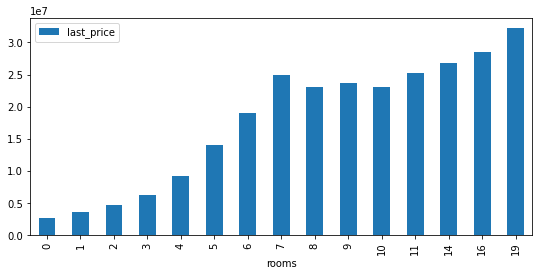

In [11]:
#влияние факторов на цену
def total_area_group (row):
    if row['total_area'] <= 40:
        return 'До 40 кв м'
    elif 40 < row['total_area'] <= 80:
        return '40-80 кв м'
    elif 80 < row['total_area'] <= 120:
        return '80-120 кв м'
    elif 120 < row['total_area'] <= 200:
        return '120-200 кв м'
    else:
        return 'Больше 200 кв м'
data['total_area_category'] = data.apply(total_area_group, axis = 1)

def living_area_group (row):
    if row['living_area'] <= 30:
        return 'До 30 кв м'
    elif 30 < row['living_area'] <= 60:
        return '30-60 кв м'
    elif 60 < row['living_area'] <= 100:
        return '60-100 кв м'
    elif 100 < row['living_area'] <= 200:
        return '100-200 кв м'
    else:
        return 'Больше 200 кв м'
data['living_area_category'] = data.apply(living_area_group, axis = 1)

def kitchen_area_group (row):
    if row['kitchen_area'] <= 10:
        return 'До 10 кв м'
    elif 10 < row['kitchen_area'] <= 20:
        return '10-20 кв м'
    elif 20 < row['kitchen_area'] <= 40:
        return '20-40 кв м'
    elif 40 < row['kitchen_area'] <= 60:
        return '40-60 кв м'
    else:
        return 'Больше 60 кв м'
data['kitchen_area_category'] = data.apply(kitchen_area_group, axis = 1)

def citycenter_km (row):
    if row['citycenter_km'] <= 5:
        return 'До 5 км'
    elif 5 < row['citycenter_km'] <= 15:
        return '5-15 км'
    elif 15 < row['citycenter_km'] <= 30:
        return '15-30 км'
    elif 30 < row['citycenter_km'] <= 45:
        return '30-45 км'
    else:
        return 'Больше 45 км'
data['citycenter_km_category'] = data.apply(citycenter_km, axis = 1)

data = data.loc[data['rooms'] != 12]
data = data.loc[data['rooms'] != 15]

#correlation function
def corr(column):
    title_dict = {'total_area','living_area','kitchen_area','rooms', 'floor_type', 'day_numb', 'month',
                  'year','citycenter_km'}
    return data['last_price'].corr(data[column])
print(corr('year'))

# #plot function
def last_price_inf(df, column):
    title_dict = {'total_area_category','living_area_category','kitchen_area_category','rooms', 'floor_type', 'day_numb', 'month',
                  'year', 'citycenter_km'}
    if column == 'floor_type':
        sort_key = 'last_price'
    else:
        sort_key = column
    df_filtered = df.groupby(column).median()['last_price'].reset_index().sort_values(by=sort_key)
    plot = df_filtered.plot(x=column, y="last_price", kind='bar', figsize=(9,4))
    return plot
last_price_inf(data, 'rooms')

Влияние факторов на стоимость квартиры:
Так как  факторы площади квартир имеют много уникальных значений, то их наглядность теряется. Поэтому было принято решение категоризовать факторы.

Цена от общей площади квартиры: очевидно, что корреляция стоимости квартиры от ее общей площади положительная и значимая. Коэффициент корреляции: 65%

Цена от жилой площади: Аналогичная корреляция видится и в данной категории. Менее значимое влияние. Коэффициент корреляции: 59%

Цена от размера кухни: согласно диаграмме, цена квартиры менее гибка к размеру кухни. Данные до сих пор видут себя корректно. Коэффициент корреляции: 44%

Цена от количества комнат: Чем больше комнат в квартире, тем она дороже. Очевидно, что цена уже не так значительно меняется, что демонстрирует коэффициент корреляции, равный 36%. Более того, был обнаружен выброс у 12-ти комнатных квартир. Изучим их более подробно для понимания природы такой аномалии в параметре количества комнат.
*Как оказалось, это та самая квартира с 900 кв м. Не смотря на то что цена за квадратный метр выглядит правдоподобной и аномалий в других параметрах не было замечено, было принято решение избавиться от данной строки для более корректного итогового вывода. Аналогичный случай с 15-ти комнатной квартирой. Эта строка больше походит на аномалию, так как квартира в СП за 112 тыс. рублей за квадратный метр маловероятна к продаже.

Цена от типа этажа: Корреляция положительна, но не существенна. Первый и последний этаж всегда чуть дешевле себе подобных квартир на 'других' этажах.

Цена от дня недели: Никакой значимой зависимости не наблюдается. Об этом свидетельствует коэффициент корреляции равный нулю.

Цена от месяца: Самые дорогие квартиры были опубликованы в апреле. Июнь - месяц с самыми низкими ценами на недвижимость.

Цена от года: Очевидная зависимость года реализации от цены. 2014 год запомнился сильным ослабеванием рубля, что сподвигает население вкладывать д.с. в недвижимость. Рынок это понимает и, в соответствии с сильным спросом, многократно увеличивал стоимость квартир (информации за 2013 нет, поэтому это лишь догадка). С начала 2015 года, рынок начал искать равновесную цену, а рубль еще не скоро окрепнет. К 2019 году, вероятно, покупательская способность населения в данной категории начала крепнуть и рынок проснулся, в связи с чем мы видим разворот графика. 

In [12]:
# #TOP10
top10 = data['locality_name'].value_counts().index.tolist()[:10]
columns = [data[data['locality_name'] == city]['price_per_1m'].median().round(0) for city in top10]
prices = [data[data['locality_name'] == city]['last_price'].median() for city in top10]
frame = {'Город': top10, 'avg_price_per_1m': columns, 'avg_price': prices}
dataframe = pd.DataFrame(frame).sort_values(by='avg_price_per_1m', ascending=False)
dataframe.reset_index(drop= True , inplace= True )
print(dataframe)

               Город  avg_price_per_1m  avg_price
0    санкт-петербург          104762.0  5500000.0
1             пушкин           99994.0  5165000.0
2    деревня кудрово           91860.0  3725000.0
3  посёлок парголово           91643.0  4090000.0
4     посёлок мурино           85714.0  3400000.0
5     посёлок шушары           76667.0  3915000.0
6            колпино           74733.0  3600000.0
7            гатчина           67672.0  3050000.0
8         всеволожск           65649.0  3450000.0
9             выборг           58001.0  2825000.0


Топ 10 городов по стоимости за кв м:
Самые дорогие квадратные метры в городе Санкт-Петербург и Пушкин. Между первым и последним местом списка разница в цене почти х2.

<AxesSubplot:xlabel='citycenter_km'>

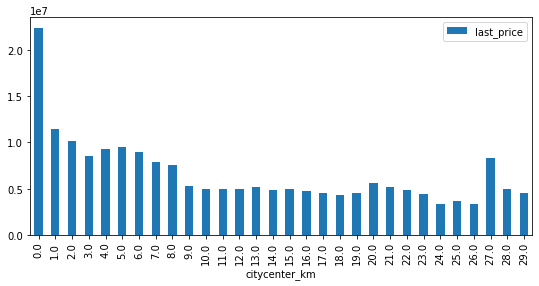

In [13]:
#RUB per km
sp_data = data.query('locality_name == "санкт-петербург"').sort_values(by = 'citycenter_km_category')
sp_data['citycenter_km'] = sp_data['citycenter_km'].round(0)
last_price_inf(sp_data, 'citycenter_km')

Цена километра: После формирования среза и построения графика видим следующую картину: самые дорогие квартиры находятся либо в самом центре города (до 5 км) или же за пределами города (более 45 км). После построения графика видим неравномерное распределение медианной цены по километражу. Тем не менее можно утверждать, что в самом центре города цена квартиры самая высокая. Между 10 и 20 километром стоимость ниже, чем на расстоянии более 20 км, что не дает нам предположить стоимость квадратного метра от километра. 

In [14]:
#Correlation
data.corr()[['last_price']].sort_values(by='last_price', ascending=False)

,last_price
last_price,1.000000
price_per_1m,0.751309
total_area,0.643881
living_area,0.581191
kitchen_area,0.428968
rooms,0.360423
ponds_around3000,0.165123
parks_around3000,0.159355
total_images,0.109586
days_exposition,0.084886


Общий вывод:
После анализа данных, можно выделить следующие аксиомы:

На цену квартиры больше всего влияет стоимость ее квадратного метра.

Общая площадь квартиры (рост квадратуры способствует росту стоимости квартиры)

Жилая площадь, площадь кухни и количество комнат оказывают второстепенное влияние, но, несомненно, при одинаковых вводных, каждый из вышеупомянутых параметров способен стать определяющим.

Расстояние от центра города формирует стоимость квартиры (одинаковые квартиры: одна в центре, другая в глуши - стоят по-разному и, естественно, стоимость квартиры в центре города будет дороже).

Небольшое влияние оказывает наличие парков или водоемов на итоговую стоимость квартиры.

При декомпозиции даты публикации объявления было выяснено, что экономическая обстановка в стране значительно сказывается на рынке недвижимости.

Многие из иных параметров, не описанных выше, оказывают несущественное влияние, но они (параметры), способны оказывать влияние на итоговую стоимость квартиры при их аккумуляции в единый параметр (как эо обычно и бывает на рынке недвижимости).


### Общий вывод

Предобработка данных:
 
 В некоторых категориях были замечены пропуски. В связи с тем, что такие категории как: ponds_nearest, cityCentres_nearest and etc. невозможно заполнить, удалить их тоже невозможно ввиду потери почти всех данных (в категории parks_nearest 15535 пропусков, в то время как совокупное количество строк данных - 23699). Не смотря на это, у каждой категории, подобной parks_nearest, есть сопряженная категория parks_around3000. Проведя анализ, было выявлено, что, если парка или пруда нет в на расстоянии 3000 у.е., то категория parks/ponds_nearest не заполнялась. Таким образом, было принято решение заполнить пропуски в категориях 'nearest', где в категории 'around3000' находится 0. После заполнения пропусков по предыдущему анализу, стало заметно, что количество пропусков в категориях 'parks_nearest - parks_around3000' и 'ponds_nearest - ponds_around3000' одинаковое, в связи с чем было предположено, что пропуски по этим парным категориям совпадают. Для того, чтобы удостовериться в своем предположении в новую переменную 'zero' был помещен срез данных, условием которого является - все пропуски категории 'parks_around3000'. Гипотеза подтвердилась и количество пропусков в срезе у сопряженных категорий совпадает, поэтому пропуски в этих 4-ех категориях были заполнены нулями. Более того, в данных присутствуют категории, где количество пропусков незначительно и им можно пренебречь: floors_total, locality_name. Утерянные данные из-за пропусков в данных категориях не нанесут существенного ущерба. Заполнить пропущенные значения вышеупомянутых категорий так же нельзя, так как невозможно выстроить логику, согласно которой будут заполняться данные пропуски. Такие категории как kitchen_area, ceiling_height, living_area и т.п. были заполнены. Пропуски категории ceiling_height были заполнены медианным значением ввиду наличия выбросов (max = 100. Нетипичная высота потолка), kitchen_area заполнены средним значением, так как данные по категории уже более "спокойные". Пропуски living_area не могут быть заполнены ни медианой, ни средним ввиду наличия категории total_area (квартира с площадью в 100 кв. м. не может быть жилой только на 5 кв. м.), в связи с чем было найдено среднее количество жилого квадратного метра на общий квадратный метр. Этот коэффициент и является средним жилым квадратным метром. При использовании такого метода мы будем уверены, что у нас нет квартиры, где количество жилой площади больше общей. По итогам заполнения пропусков, в датафрейме осталось 3 категории, которые мы не можем заполнить с уверенностью, что новые данные не искозят итоговый анализ: airports_nearest, cityCenters_nearest и days_exposition. У данных категорий нет сопряженных данных, которые могли бы нам помочь решить, сможем ли мы заполнить пропуски объективно-верными значениями, которые не исказят итоговый анализ. Справедливо заметить, что такие категории, как: balcony и is_apartment, которые являются буллевыми - вероятней всего могут быть не заполнены, в случае, если у квартиры нет балкона или эта квартира - не апартаменты. В соответствии с этой гипотезой, пропуски были заменены на 'False'. 
 
 Типы данных:
 
 Некоторые категории требовали изменения типа данных: floors_total, balcony, parks_around3000, ponds_around3000. Все категории получили тип 'int', так как количество этажей, балконов, парков и прудов поблизости не может быть дробным. Таким образом, можно утверждать, что данные прошли предобработку и теперь с ними можно работать. 
 
 Дубликаты:
 
 Предполагается, что дубликаты в названии населенных пунктов 'locality_name' могли возникнуть в результате использования букв е/ё, использования или не использования верхнего регистра, а так же различной классификации населенного пукнта (поселок, поселок городского типа, деревня и тд). В связи с чем было принято решение в новом столбце 'locality_name_clear' избавиться от описанного выше шума.
 
Анализ: 
1. Большая часть квартир имеет метраж от 30 до 80 кв.м., пик приходится на 50 кв.м. Есть квартиры и по 800м, но это единичные выбросы.
2. Цена на квартиры лежит в промежутке от 3 до 12 млн. Большая часть квартир продается за цену в промежутке между 3 и 6 млн. Опять же, есть выбросы.
3. Большая часть квартир имеют 1 или 2 комнаты, чуть меньший процент имеют 3 комнаты и небольшое количество - 4. Есть и квартиры, имеющие больше комнат, но их процент сильно ниже.
4. Квартиры, в большинстве своем, имеют потолки от 2,5-2,75м (самый популярный вариант) до 3,2м. Остальные случаи - эксклюзивы.
5. Квадратура большинства кухонь не достигает 20 кв. м, но существуют квартиры и с большими кухнями.
6. Самые редкие квартиры на рынке - квартиры на 1-ом этаже. На последнем этаже примерно на 40% квартир на рынке. Не смотря на это, суммарно первый и последний этаж составляют всего 20% от общего числа квартир, реализуемых на рынке.
7. Абсолютное большинство квартир находится в нижней части дома, не выше 5 этажа.
8. В среднем квартиры находятся на расстоянии 10-20 км от центра. Есть объекты и в 60 км от центра.

Анализ скорости продажи квартиры:
    Большинство квартир реализованы за 50 дней и менее. Распределение нормально, что отражает редкость такого явления, как продажа квартиры больше 400 дней.
    Построив ящик с усами, можем заметить, что выбросами являются сделки спустя 500 дней и более. Для более детального анализа временно отбросим такие строки.
    Построив гистограмму с очищенными от выбросов данными, выделяются несколько временных промежутков. Ориентировочно это 40, 60, 80 дней. Сделаем срез 40 - 100 дней реализации для понимания природы таких аномальных частот.
    Построенная по срезу гистограмма свидетельствует о том, что аномально часто квартиры продают именно в 45, 60 и 90-ый день. Справедливо предположить, что обяъвление может висеть только 45 дней, а дальше можно продлить объявление на 15 или 45 дней. Справедливо предположить, что данные по автозакрытиям объявлений портят общую картину.
    
Влияние факторов на стоимость квартиры:
Так как  факторы площади квартир имеют много уникальных значений, то их наглядность теряется. Поэтому было принято решение категоризовать факторы.

Цена от общей площади квартиры: очевидно, что корреляция стоимости квартиры от ее общей площади положительная и значимая. Коэффициент корреляции: 65%

Цена от жилой площади: Аналогичная корреляция видится и в данной категории. Менее значимое влияние. Коэффициент корреляции: 59%

Цена от размера кухни: согласно диаграмме, цена квартиры менее гибка к размеру кухни. Данные до сих пор видут себя корректно. Коэффициент корреляции: 44%

Цена от количества комнат: Чем больше комнат в квартире, тем она дороже. Очевидно, что цена уже не так значительно меняется, что демонстрирует коэффициент корреляции, равный 36%. Более того, был обнаружен выброс у 12-ти комнатных квартир. Изучим их более подробно для понимания природы такой аномалии в параметре количества комнат.
*Как оказалось, это та самая квартира с 900 кв м. Не смотря на то что цена за квадратный метр выглядит правдоподобной и аномалий в других параметрах не было замечено, было принято решение избавиться от данной строки для более корректного итогового вывода. Аналогичный случай с 15-ти комнатной квартирой. Эта строка больше походит на аномалию, так как квартира в СП за 112 тыс. рублей за квадратный метр маловероятна к продаже.

Цена от типа этажа: Корреляция положительна, но не существенна. Первый и последний этаж всегда чуть дешевле себе подобных квартир на 'других' этажах.

Цена от дня недели: Никакой значимой зависимости не наблюдается. Об этом свидетельствует коэффициент корреляции равный нулю.

Цена от месяца: Самые дорогие квартиры были опубликованы в апреле. Июнь - месяц с самыми низкими ценами на недвижимость.

Цена от года: Очевидная зависимость года реализации от цены. 2014 год запомнился сильным ослабеванием рубля, что сподвигает население вкладывать д.с. в недвижимость. Рынок это понимает и, в соответствии с сильным спросом, многократно увеличивал стоимость квартир (информации за 2013 нет, поэтому это лишь догадка). С начала 2015 года, рынок начал искать равновесную цену, а рубль еще не скоро окрепнет. К 2019 году, вероятно, покупательская способность населения в данной категории начала крепнуть и рынок проснулся, в связи с чем мы видим разворот графика. 


Топ 10 городов по стоимости за кв м:
Самые дорогие квадратные метры в городе Санкт-Петербург и Пушкин. Между первым и последним местом списка разница в цене почти х2.

Цена километра: После формирования среза и построения графика видим следующую картину: самые дорогие квартиры находятся либо в самом центре города (до 5 км) или же за пределами города (более 45 км). После построения графика видим неравномерное распределение медианной цены по километражу. Тем не менее можно утверждать, что в самом центре города цена квартиры самая высокая. Между 10 и 20 километром стоимость ниже, чем на расстоянии более 20 км, что не дает нам предположить стоимость квадратного метра от километра. 



Общий вывод:
После анализа данных, можно выделить следующие аксиомы:

На цену квартиры больше всего влияет стоимость ее квадратного метра.

Общая площадь квартиры (рост квадратуры способствует росту стоимости квартиры)

Жилая площадь, площадь кухни и количество комнат оказывают второстепенное влияние, но, несомненно, при одинаковых вводных, каждый из вышеупомянутых параметров способен стать определяющим.

Расстояние от центра города формирует стоимость квартиры (одинаковые квартиры: одна в центре, другая в глуши - стоят по-разному и, естественно, стоимость квартиры в центре города будет дороже).

Небольшое влияние оказывает наличие парков или водоемов на итоговую стоимость квартиры.

При декомпозиции даты публикации объявления было выяснено, что экономическая обстановка в стране значительно сказывается на рынке недвижимости.

Многие из иных параметров, не описанных выше, оказывают несущественное влияние, но они (параметры), способны оказывать влияние на итоговую стоимость квартиры при их аккумуляции в единый параметр (как эо обычно и бывает на рынке недвижимости).
